# Colab_APPRAISE notebook


This is a note book that allows performing APPRAISE pipeline on Google Colab step-by-step.

All results are saved in your Google Drive after each step. You can safely terminate a session between steps, although you'll need to re-run step 0 every time you restart.

Author: Xiaozhe Ding (Email: xding@caltech.edu, dingxiaozhe@gmail.com; Twitter: [@DingXiaozhe](https://twitter.com/dingxiaozhe?lang=en))

If you have any questions when using the notebook, please feel free to raise an issue in Github or shoot an email to me.

### Step 0 - Prepare environment (run everytime you restart a new session)

In [ ]:
#@title ####0.1 Mount google drive

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#@title ####0.2 Install APPRAISE package

!pip install appraise

### Step 1 Prepare input files for competitive structure modeling

In [ ]:
import appraise
from appraise.utilities import *
from appraise.input_fasta_prep import *

#@markdown ###**Basic settings**
csv_file_path = '/content/drive/MyDrive/APPRAISE_project_1/input_csv/candidate_peptide_list.csv' #@param {type:"string"}
#@markdown - The .csv spreadsheet containing names and sequences of candidate engineered proteins.
#@markdown - The spreadsheet should contain at least two columns titled "peptide_name" and "peptide_seq", respectively. 
#@markdown - You may check [an example csv file](https://github.com/xz-ding/APPRAISE/blob/main/demo/demo_100AAV_screening/stage_1/AAV_mock_selection_100_peptide_list.csv) provided in the [demo](https://github.com/xz-ding/APPRAISE/tree/main/demo).

folder_path_for_fastas = '/content/drive/MyDrive/APPRAISE_project_1/structure_modeling_input_fastas' #@param {type:"string"}
#@markdown - The destination folder that will contain the fasta files for structure modeling.

receptor_name = 'Ly6a' #@param {type:"string"}
#@markdown - Name of the receptor.


receptor_seq = "LECYQCYGVPFETSCPSITCPYPDGVCVTQEAAVIVDSQTRKVKNNLCLPICPPNIESMEILGTKVNVKTSCCQEDLCNVAVP" #@param {type:"string"}
#@markdown - Receptor sequence to be used for modeling. 
#@markdown - We recommend using the minimal self-folding domain that is essential for the binding interaction to achieve the highest speed and accuracy.
#@markdown - Disordered sequences that are non-essential for binding may decrease the accuracy of modeling and should be truncated. Tips: 1. Truncated, crystallographic constructs used by structural biologists are usually good for modeling, if an experimental structure of the receptor is available; 2. You can also model the full-length receptor sequence using [ColabFold](https://github.com/sokrypton/ColabFold/blob/main/AlphaFold2.ipynb) and find out the low-confidence (e.g., pLDDT < 50) terminal sequences that may be truncated.

competition_mode = 'pairwise' #@param ['pairwise', 'pooled', 'single']{type:"string"}
#@markdown - Modes of competition:
#@markdown -- **pairwise** Two candidate engineered proteins compete for a receptor. All possible pairs will be modeled exhaustively.
#@markdown -- **pooled** Candidate proteins will be grouped into fixed-sized groups and compete within the group. Each candidate protein will be in one group only. 
#@markdown -- **single** Complex models of one single engineered protein and the receptor will be modeled.


##################################################
#@markdown ###**Options for pairwise competition**
##################################################
square_matrix = True #@param {type:"boolean"}
#@markdown - If True, all peptides in the list will be competing with each oter through a complete tournament. 
#@markdown - If False, each peptide from the csv file above will be competing with each peptide from another spreadsheet. You'll need to provide the path to other .csv spreadsheet.
csv_file_path_2 = 'N/A' #@param {type:"string"}
#@markdown - Provide path to the additional .csv spreadsheet if square_matrix is False.


##################################################
#@markdown ###**Options for pooled competition**
##################################################
pool_size = '4' #@param ['2', '3', '4'] {type:"string"}
#@markdown - The number of candidates in each pool. 
random_seed = 42 #@param{type:'integer'}
#@markdown - The seed for random grouping. The same seed number will result in the same grouping.
#@markdown - It is recommended to model with multiple different seeds (groupings) to reduce the stochasticity of results. (You may simply change the seed number and run this cell multiple times. Fasta files with different groupings will be merged in the same folder.)


##################################################
#@markdown ###**Advanced options**
##################################################

use_glycine_linker = False #@param {type:"boolean"}
#@markdown - If True, the complex models will be modeled as a single chain protein joint with glycines.
#@markdown - Use this option if you intend to predict the structures with **ESMFold**.

glycine_linker_length=30 #@param {type:"integer"}
#@markdown - If use_glycine_linker is True, use this variable to adjust the length of glycine linker.

prepare_receptor_model = True #@param {type:"boolean"}
#@markdown - If True, a single-chain model with only the receptor will be modeled. The modeled structure can later be uploaded to [HullRad server](http://52.14.70.9/Run_hullrad.html) to measure the geometry properties of the receptor.

peptide_names, peptide_seqs = load_peptides(csv_file_path)
peptide_names_2=[], peptide_seqs_2=[]
if competition_mode == 'pairwise' and square_matrix == 'False':
    peptide_names_2, peptide_seqs_2 = load_peptides(csv_file_path_2)


list_query_sequence, list_jobname = get_complex_fastas(receptor_name=receptor_name, receptor_seq=receptor_seq, list_peptide1_names=peptide_names,\
                                    list_peptide1_seqs=peptide_seqs, mode=competition_mode, square_matrix=square_matrix,\
                                    list_peptide2_names=peptide_names_2, list_peptide2_seqs=peptide_seqs_2, pool_size=pool_size,\
                                    folder_path=folder_path_for_fastas, use_glycine_linker=use_glycine_linker,\
                                    glycine_linker_length=glycine_linker_length, random_seed=random_seed,\
                                    prepare_receptor_model=prepare_receptor_model)

### Step 2 - Run structure prediction

**Instruction** 


The structures can be modeled using AlphaFold2-multimer or other state-of-the-art structure-prediction tools. 

For easy access to AlphaFold2-multimer, we suggest using ColabFold, an integrated implementation of multiple sequence alignment and AlphaFold (Mirdita M, Schütze K, Moriwaki Y, Heo L, Ovchinnikov S and Steinegger M. ColabFold: Making protein folding accessible to all., Nature Methods (2022) doi: 10.1038/s41592-022-01488-1).

To use the ColabFold notebook, you can make a copy of [the ColabFold-batch notebook](https://github.com/sokrypton/ColabFold/blob/main/batch/AlphaFold2_batch.ipynb) to a Google account, upload fasta files to the input folder, set the input fasta folder to be the folder defined by ```folder_path_for_fastas``` in Step 1, and hit "run all" in the Colab notebook.  Suggested settings:

```

msa_mode = MMseqs2 (UniRef+Environmental)

num_models = 5

num_recycles = 3

stop_at_score = 100

use_amber = False

use_templates = True

do_not_overwrite_results = False

zip_results = False

model_type = "auto" #In colabfold 2.1.14, AlphaFold2-multimer-v2 is used by default.

```


Note: 

1. Run the following line in a new cell in your ColabFold notebook and take a note on what GPU model is being used in the Colab session. This will be helpful when you need to reproduce the modeling results. We found that using the same GPU gives the most consistent (near-deterministic) modeling results.

```
!nvidia-smi
```

2. If you wish to use another version of AlphaFold model (e.g., AlphaFold2-multimer-v1) in the Colab batch notebook, you will need to make two modifications manually. First, copy the lines below and paste it to the top of the "Run prediction" block so that the notebook can download the correct parameters. Second, change the "model_type" argument in the line with "run(...)" in the "Run prediction" block to the desired model type.
```
# Force to download for the appropriate model type
model_type = "AlphaFold2-multimer-v1" #See ColabFold documentation for other available model types
from colabfold.download import download_alphafold_params
from pathlib import Path
download_alphafold_params(model_type, Path("/root/.cache/colabfold/"))
```

If your session is terminated in the middle, You can delete the input fasta files for the models that were already finished and restart the session to continue with the rest. Sometimes you may need to wait for hours to regain access to a GPU session.

### Step 3 - Quantify structure models

In this step, you will use PyMOL script appraise/pymol_quantify_peptide_binding.py to analyze the pdb files in a folder and generate a csv file containing all measurements in parent folder of the pdb results folder. 

*Notes:*

*1. If you did not use ColabFold for the modeling, the file names of the models need to be changed to the following format, where the bracketed part can be any filler string with a total length of 14 characters:*
```
'ReceptorName_and_Peptide1Name_vs_Peptide2Name_vs_..._vs_PeptideNName_unrelaxed_[14Characters].pdb'
```
*2. Currently ,the Colab notebook only allows you to run the script with default parameters (for example, the anchor site defaults to the C-terminus). If you need to change the parameters for the quantification function, use Advanced approach below instead.*


In [ ]:
#@markdown #### 3.1 Install open-source PyMOL


#@markdown The installation code was copied from [colabOpenSourcePyMOLpySnips](https://github.com/MooersLab/colabOpenSourcePyMOLpySnips) by Dr. Blaine Mooers.

from IPython.utils import io
import tqdm.notebook
import os
"""The PyMOL installation is done inside two nested context managers. This approach
was inspired by Dr. Christopher Schlick's (of the Phenix group at
Lawrence Berkeley National Laboratory) method for installing cctbx
in a Colab Notebook. He presented his work on September 1, 2021 at the IUCr
Crystallographic Computing School. I adapted Chris's approach here. It replaces my first approach
that requires seven steps. My approach was presentated at the SciPy2021 conference
in July 2021 and published in the
[proceedings](http://conference.scipy.org/proceedings/scipy2021/blaine_mooers.html).
The new approach is easier for beginners to use. The old approach is easier to debug
and could be used as a back-up approach.

Thank you to Professor David Oppenheimer of the University of Florida for suggesting the use mamba and of Open Source PyMOL.
"""
total = 100
with tqdm.notebook.tqdm(total=total) as pbar:
    with io.capture_output() as captured:

        !pip install -q condacolab
        import condacolab
        condacolab.install()
        pbar.update(10)

        import sys
        sys.path.append('/usr/local/lib/python3.7/site-packages/')
        pbar.update(20)

        # Install PyMOL
        %shell mamba install pymol-open-source --yes

        pbar.update(70)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
#@markdown #### 3.2 Run the analysis script

#@markdown **Change the folder path if needed:**
folder_path_for_predicted_structures = '/content/drive/MyDrive/APPRAISE_project_1/structure_modeling_results' #@param {type:"string"}
#@markdown - The folder should contain the structure prediction results.


# Get the path to the script
import appraise
import os
script_path = '/'.join(os.path.abspath(appraise.__file__).split('/')[:-2]) + '/appraise/pymol_quantify_peptide_binding.py'

# Execute script
!pymol -cq $script_path $folder_path_for_structure_results

You will need to replace "/path/to/APPRAISE" with the actual path. You might also need to change "pymol" to the actual location of the executable, depending on your operation system and PyMOL release.

#### (Advanced) Alternative step 3

You can run the quantification script in a local installation of PyMOL using **PyMOL prompt**, which gives you **more control** of the parameters to be used for analysis. For example, you can change the anchor point of the receptor from the default (C-terminus) to the N-terminus or any other residues.

First, you need a copy of the PyMOL script. If you already have a local installation of [APPRAISE package](https://pypi.org/project/appraise/), the script is also included in the package. If you don't have the package, you can also download the standalone PyMOL script [here](https://github.com/xz-ding/APPRAISE/blob/main/appraise/pymol_quantify_peptide_binding.py). 

Then, in PyMOL GUI, load the script and call the quantify_binding function with appropriate arguments.

For example:

```
# Load the script (replace "/path/to/APPRAISE" with the actual path)
run /path/to/APPRAISE/appraise/pymol_quantify_peptide_binding.py

# Call the quantification function (change the parameters as needed)
quantify_binding('path_to_results_folder/', use_relaxed=False, time_stamp=True, mod_start_resi=3, mod_end_resi=9, pLDDT_threshold=0, membrane_anchor_site='N-term')
```

*Note: The script will take a few minutes to run, and the PyMOL GUI might be frozen while the script is running, which is normal.*

### Step 4 - Analyze quantification results

#### Step 4A - Analyze pairwise competition results

In [ ]:
#@markdown #### 4A.1 Load structure quantification resutls

# Import common packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import necessary APPRAISE modules
import appraise
from appraise.utilities import *
from appraise.score_calculation import *

# Get the settings
#@markdown **Basic settings**

database_path = '/content/drive/MyDrive/APPRAISE_project_1/structure_modeling_results/APPRAISE_database.csv' #@param {type:"string"}
#@markdown - Path to quantification database file (*.csv)


APPRAISE_version = '1.2' #@param ['1.0', '1.1', '1.2'] {type:"string"}
APPRAISE_version = float(APPRAISE_version)
#@markdown - Version of APPRAISE to use

#@markdown **Receptor hydrodynamic properties**

receptor_of_interest = 'Ly6a' #@param {type:"string"}
#@markdown - Receptor of interest (need to match the name in input fasta file names)
receptor_Dmax = 46.68 #@param {type:"number"}
receptor_AxialRatio = 1.74 #@param {type:"number"}
receptor_Rminor = receptor_Dmax/receptor_AxialRatio/2 
#@markdown - You may calculate hydrodynamic properties of your receptor (**receptor_Dmax** and **receptor_AxialRatio**) using the [HullRad server](http://52.14.70.9/Run_hullrad.html). Upload a pdb containing the **receptor only** model to the server and record the **Dmax** and **Axial ratio**. (By default setting, you should have already got 5 predicted receptor-only models in folder_path_for_predicted_structures. Simply upload the model that is ranked #1 to HullRad server.)
#@markdown - Rminor, the hydrodynamic radius along the minor axis of the receptor (considered as an ellipsoid), is automatically calculated using the formula Rminor = Dmax / AxialRatio / 2.



# Read and calculate scores
df = pd.read_csv(database_path)
df = df.loc[df['receptor_name'] == receptor_of_interest].copy()
df['receptor_Rminor'] = receptor_Rminor
list_peptide_names, list_peptide_seqs = get_peptide_list_from_model_names(df)

df_sorted = sort_df_by_peptides_and_cleanup(df, list_peptide_names)

print('\nA database with {} peptides is successfully loaded! \n'.format(len(list_peptide_names)))

# Quality check
database_quality_check(df_sorted)

In [ ]:
#@markdown #### 4a.2 Load structure quantification resutls
#@markdown Calculate the binding scores from each individual competition ($\Delta B_2^{POI, competitor}$):

# Get a dataframe that is sorted pair-wise
df_pairwise_sorted = sort_df_by_peptides_and_cleanup(df, list_peptide_names)

# Calculate the pair-wise scores
df_pairwise_sorted = calculate_scores(df_pairwise_sorted, version=APPRAISE_version, depth_constraint=True)
print('Binding scores from each individual competition:')
df_pairwise_sorted[['peptide_name','competitor','Delta_B']]

Binding scores from each individual competition:


,peptide_name,competitor,Delta_B
688,SRK-50,SRK-50,111.608204
689,SRK-50,SRK-50,-111.608204
1066,SRK-50,SRK-50,124.474408
1067,SRK-50,SRK-50,-124.474407
1654,SRK-50,SRK-50,77.352103
...,...,...,...
1885,SRK-30,SRK-30,-147.413749
2696,SRK-30,SRK-30,3.245493
2697,SRK-30,SRK-30,-3.245493
2788,SRK-30,SRK-30,-0.734358


Get the mean binding scores ($\overline{\Delta B}_2^{POI, competitor}$)

In [ ]:
# Sort the peptides
df_pairwise_average = df_pairwise_sorted.groupby(by=['peptide_name','competitor','peptide_seq']).mean().dropna(subset=['Delta_B']).reset_index()
print('Mean binding scores:')
df_pairwise_average[['peptide_name','competitor','Delta_B']]

Mean binding scores:


,peptide_name,competitor,Delta_B
0,SRK-50,SRK-50,-2.391168e-07
1,SRK-50,Dis90,-5.049392e+01
2,SRK-50,SRK-67,1.485454e+01
3,SRK-50,SRK-39,-1.332436e+00
4,SRK-50,PHP.B,2.876579e+01
...,...,...,...
319,SRK-30,SRK-74,1.721103e+01
320,SRK-30,SRK-90,5.382421e+01
321,SRK-30,SRK-61,-7.066898e+01
322,SRK-30,SRK-64,4.920453e+01


Run the following code block to get a the absolute binding scores of the variants and a list of top peptides that can be used for stage 2.

The results will be saved in the save directory as the database.

Used p-value threshold of 0.050
Tie threshold to be 2.26 of standard deviation: 32.84


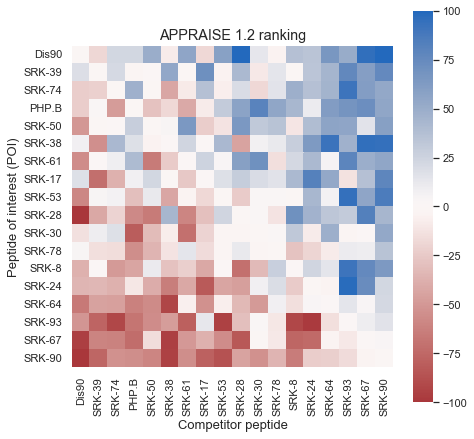

In [ ]:
list_peptide_order, _, _ = plot_heatmap(df_pairwise_average, feature_of_interest='Delta_B', title='APPRAISE 1.2 ranking', rank_by_tournament=True, save_figure=False, p_value_threshold=0.05, vmin=-100, vmax=100)
heatmap_figure_path = '/'.join(database_path.split('/')[:-1]) + '/stage_2_results_matrix.png'
plt.savefig(heatmap_figure_path, bbox_inches = 'tight', dpi=300)

In [ ]:
print('APPRAISE analysis finished!')
print('The final ranking is: {}'.format(list_peptide_order))
print('The heatmap is saved as {}'.format(heatmap_figure_path))

APPRAISE analysis finished!
The final ranking is: ['Dis90', 'SRK-39', 'SRK-74', 'PHP.B', 'SRK-50', 'SRK-38', 'SRK-61', 'SRK-17', 'SRK-53', 'SRK-28', 'SRK-30', 'SRK-78', 'SRK-8', 'SRK-24', 'SRK-64', 'SRK-93', 'SRK-67', 'SRK-90']
The heatmap is saved as ./demo_100AAV_screening/stage_2/Ly6a_ranked_by_Delta_B.png


#### Step 4b - Analyze pooled competition results

In [ ]:
#@markdown #### 4.1 Load structure quantification resutls

# Import common packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import necessary APPRAISE modules
import appraise
from appraise.utilities import *
from appraise.score_calculation import *

# Get the settings
#@markdown **Basic settings**

database_path = '/content/drive/MyDrive/APPRAISE_project_1/structure_modeling_results/APPRAISE_database.csv' #@param {type:"string"}
#@markdown - Path to quantification database file (*.csv)


APPRAISE_version = '1.2' #@param ['1.0', '1.1', '1.2'] {type:"string"}
APPRAISE_version = float(APPRAISE_version)
#@markdown - Version of APPRAISE to use

#@markdown **Receptor hydrodynamic properties**

receptor_of_interest = 'Ly6a' #@param {type:"string"}
#@markdown - Receptor of interest (need to match the name in input fasta file names)
receptor_Dmax = 46.68 #@param {type:"number"}
receptor_AxialRatio = 1.74 #@param {type:"number"}
receptor_Rminor = receptor_Dmax/receptor_AxialRatio/2 
#@markdown - You may calculate hydrodynamic properties of your receptor (**receptor_Dmax** and **receptor_AxialRatio**) using the [HullRad server](http://52.14.70.9/Run_hullrad.html). Upload a pdb containing the **receptor only** model to the server and record the **Dmax** and **Axial ratio**. (By default setting, you should have already got 5 predicted receptor-only models in folder_path_for_predicted_structures. Simply upload the model that is ranked #1 to HullRad server.)
#@markdown - Rminor, the hydrodynamic radius along the minor axis of the receptor (considered as an ellipsoid), is automatically calculated using the formula Rminor = Dmax / AxialRatio / 2.



# Read and calculate scores
df = pd.read_csv(database_path)
df = df.loc[df['receptor_name'] == receptor_of_interest].copy()
df['receptor_Rminor'] = receptor_Rminor
list_peptide_names, list_peptide_seqs = get_peptide_list_from_model_names(df)

df_sorted = sort_df_by_peptides_and_cleanup(df, list_peptide_names)

print('\nA database with {} peptides is successfully loaded! \n'.format(len(list_peptide_names)))

# Quality check
database_quality_check(df_sorted)

##### Rank by mean aboslute binding score ($\overline{B}_2^{POI}$)

Calculate binding scores from each individual competition ($B_2^{POI, competitor}$):

In [ ]:
df = calculate_scores(df, version=APPRAISE_version)
print('Binding scores from individual competitions:')
df[['peptide_name','B_POI']]

Binding scores from individual competitions:


,peptide_name,B_POI
0,SRK-42,0.007719
1,SRK-30,204.652401
2,SRK-73,16.653166
3,Dis90,52.824447
4,SRK-24,105.655108
...,...,...
995,AAV9,-0.000000
996,SRK-77,-0.000000
997,SRK-33,131.627629
998,SRK-64,18.282947


Get the mean binding scores ($\overline{B}_2^{POI}$)

In [ ]:
# Sort the peptides
df_average_by_POI = df.groupby(by=['peptide_name','peptide_seq']).mean().dropna(subset=['B_POI']).reset_index()
print('Mean binding scores of each POI:')
df_average_by_POI[['peptide_name','B_POI']]

Mean binding scores of each POI:


,peptide_name,B_POI
0,SRK-86,29.971276
1,SRK-58,24.680393
2,SRK-4,41.219688
3,AAV9,0.586392
4,SRK-85,57.935931
...,...,...
95,SRK-59,52.264803
96,SRK-19,55.705604
97,SRK-51,34.713927
98,SRK-32,20.521815


Run the following code block to get a the absolute binding scores of the variants and a list of top peptides that can be used for stage 2.

The results will be saved in the save directory as the database.

In [ ]:
# Select the top variants
N_top = int(interactive_input('Number of top variants to keep', 18))
df_average_by_POI = df_average_by_POI.sort_values(by='B_POI', ascending=False).reset_index()
df_selected_peptides = df_average_by_POI.loc[0:N_top-1, ['peptide_name', 'peptide_seq', 'B_POI']]


#Save the results
print('\nSuccess!')
score_file_path = '/'.join(database_path.split('/')[:-1]) + '/APPRAISE{}_scores_of_all_peptides.csv'.format(str(APPRAISE_version))
df_average_by_POI.to_csv(score_file_path)
print('\nThe APPRAISE scores of peptide variants are saved in {}'.format(score_file_path))
selected_peptide_list_path = '/'.join(database_path.split('/')[:-1]) + '/APPRAISE{}_selected_top_{}_peptides.csv'.format(str(APPRAISE_version), str(N_top))
df_selected_peptides.to_csv(selected_peptide_list_path)
print('\nThe list of selected peptides is saved as {}'.format(selected_peptide_list_path))

# Display the results
print('\nHere is the list of selected peptide variants:\n')
df_selected_peptides

Default Number of top variants to keep is [18], need to change? Provide new value or hit Enter to use default


>  



Success!

The APPRAISE scores of peptide variants are saved in ./demo_100AAV_screening/stage_1/APPRAISE1.2_scores_of_all_peptides.csv

The list of selected peptides is saved as ./demo_100AAV_screening/stage_1/APPRAISE1.2_selected_top_18_peptides.csv

Here is the list of selected peptide variants:



,peptide_name,peptide_seq,B_POI
0,SRK-53,AQLTSSNALAQAQTG,140.082737
1,SRK-50,AQNNFNASLAQAQTG,139.588552
2,Dis90,AQWKNMGLQAQAQTG,104.001532
3,SRK-28,AQIVSNQMSAQAQTG,99.594279
4,SRK-24,AQFNSKLQLAQAQTG,95.451241
5,SRK-8,AQTHDAQAWAQAQTG,94.841946
6,SRK-93,AQSVSTPRGAQAQTG,89.622684
7,SRK-61,AQNHMVRELAQAQTG,84.464261
8,SRK-90,AQNKLTANGAQAQTG,82.948237
9,SRK-74,AQIPVSIQAAQAQTG,80.966634


##### Plot the results

The following code block shows an example to create an overview plot of scores of individual models.

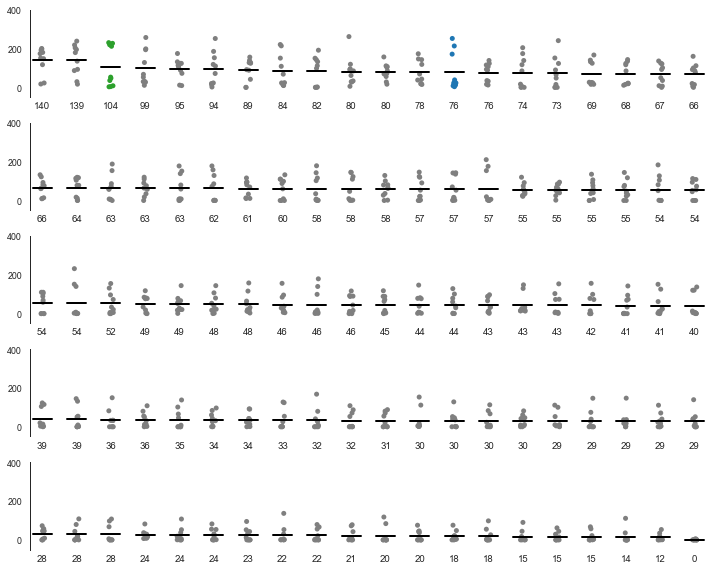

In [ ]:
# Set number of subplots
n_rows = 5
n_columns = 20

# Configure the plot
sns.set_style("white")
sns.set_context("paper")

plt.rcParams["figure.figsize"] = (10, 8)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_columns)

# Plot each peptide in a subplot
for i, peptide_name in enumerate(df_average_by_POI['peptide_name']):
    j = i // n_columns
    k = i % n_columns
    
    # Set the y axis display rules depending on the position
    if k == 0:
        sns.despine(bottom = True, left=False, right=True, ax=axes[j, k])
    else:
        sns.despine(bottom = True, left=True, right=True, ax=axes[j, k])
        axes[j,k].set(yticklabels=[])
 
    # Set coloring -- highlight PHP.B, Dis90, and AAV9
    if peptide_name == 'PHP.B':
        color_setting = sns.color_palette()[0]
    elif peptide_name == 'Dis90':
        color_setting = sns.color_palette()[2]
    elif peptide_name == 'AAV9':
        color_setting = sns.color_palette("tab10")[7]
    else:
        color_setting = sns.color_palette()[7]
    
    # Plot the data points
    sns.stripplot(ax=axes[j,k], y="B_POI", data=df.loc[df['peptide_name']==peptide_name], color=color_setting)
    
    # Plot the mean bar
    sns.boxplot(ax=axes[j,k], 
            showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            y="B_POI",
            data=df.loc[df['peptide_name']==peptide_name],
            showfliers=False,
            showbox=False,
            showcaps=False)
    
    # Annotate the reads
    axes[j, k].annotate(int(np.mean(df.loc[df['peptide_name']==peptide_name, "B_POI"])), xy=(0.5, -0.1), xycoords='axes fraction', ha='center', va='center')
    #axes[j, k].set_title(variable_name, wrap=True)
    axes[j,k].set_ylim(-50, 400)
    axes[j,k].set_xlabel('')
    axes[j,k].set_ylabel('')
    axes[j,k].set(xticklabels=[])
   
    
plt.tight_layout()
fig.savefig('/'.join(database_path.split('/')[:-1]) + '/stage_1_results.png', dpi=300)


***Demo instruction: This step is the rate-limiting step. You can skip to step 2.4 using a provided sample table instead.***

The structures can be modeled using AlphaFold2-multimer or other state-of-the-art structure-prediction tools. 

For easy access to AlphaFold2-multimer, we suggest using ColabFold, an integrated implementation of multiple sequence alignment and AlphaFold (Mirdita M, Schütze K, Moriwaki Y, Heo L, Ovchinnikov S and Steinegger M. ColabFold: Making protein folding accessible to all., Nature Methods (2022) doi: 10.1038/s41592-022-01488-1).

To use the ColabFold notebook, you can make a copy of [the ColabFold-batch notebook](https://github.com/sokrypton/ColabFold/blob/main/batch/AlphaFold2_batch.ipynb) to a Google account, upload fasta files to the input folder, and hit "run all" in the Colab notebook.  Suggested settings:

```

msa_mode = MMseqs2 (UniRef+Environmental)

num_models = 5

num_recycles = 3

stop_at_score = 100

use_amber = False

use_templates = True

do_not_overwrite_results = False

zip_results = False
```


Note: 

1. Run the following line in a new cell in your ColabFold notebook and take a note on what GPU model is being used in the Colab session. This will be helpful when you need to reproduce the modeling results. We found that using the same GPU gives the most consistent (near-deterministic) modeling results.

```
!nvidia-smi
```

2. If you wish to use another version of AlphaFold model (e.g., AlphaFold2-multimer-v1) in the Colab batch notebook, you will need to make two modifications manually. First, copy the lines below and paste it to the top of the "Run prediction" block so that the notebook can download the correct parameters. Second, change the "model_type" argument in the line with "run(...)" in the "Run prediction" block to the desired model type.
```
# Force to download for the appropriate model type
model_type = "AlphaFold2-multimer-v1" #See ColabFold documentation for other available model types
from colabfold.download import download_alphafold_params
from pathlib import Path
download_alphafold_params(model_type, Path("/root/.cache/colabfold/"))
```

If your session is terminated in the middle, You can delete the input fasta files for the models that were already finished and restart the session to continue with the rest. Sometimes you may need to wait for hours to regain access to a GPU session.